In [1]:
import torch as th
import numpy as np
import random

#сделаем инициализацию random seed,
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [2]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/Users/vladamalkina/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/vladamalkina/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/vladamalkina/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/vladamalkina/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [6]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

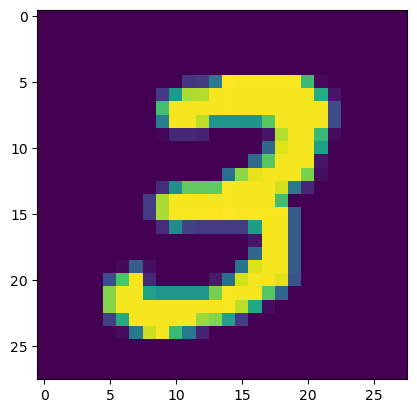

tensor(3)


In [7]:
#посмотрим на картинки
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

In [8]:
#у нас трезмерный тензор, мы хотим двумерный тензор,
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [9]:
#Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(th.nn.Module):
    def __init__(self, n):
        super (MNISTnet, self).__init__()
        self.fc1 = th.nn.Linear(28*28, n)
        self.act1 = th.nn.Sigmoid()
        self.fc2 = th.nn.Linear(n, n)
        self.act2 = th.nn.Tanh()
        self.out = th.nn.Linear(n, 10)
        self.sm = th.nn.Softmax(dim=1)


    def forward(self, x):
        x = th.flatten(x, 1)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.out(x)
        return x
        

    def predict(self, x):
        with th.no_grad():
            x = self.forward(x)
            x = self.sm(x)
            return x

In [10]:
#лосс функция
criterion = th.nn.CrossEntropyLoss()

In [11]:
def learn_func(model, opt):
    train_losses = []
    test_losses = []

    batch_size = 50 
    epochs = 40 

    for epoch in range(epochs):
        order = np.random.permutation(len(X_train))
        for start_index in range (0,len(X_train), batch_size):

            opt.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            batch_X = X_train[batch_indexes]
            batch_y = y_train[batch_indexes]

            preds = model.forward(batch_X)
            loss_val = criterion(preds, batch_y)
            loss_val.backward()
            opt.step()

        preds = model.predict(X_train)
        loss_val = criterion(preds, y_train)
        train_losses.append(loss_val.item())

        test_preds = model.predict(X_test)
        loss = criterion(test_preds, y_test)
        test_losses.append(loss.item())

    test_preds = model.predict(X_test)
    print((test_preds.argmax(dim=1) == y_test).float().mean())
    return test_losses

# ADAM

In [12]:
net_30_adam = MNISTnet(30)
optimizer_net_30_adam = th.optim.Adam(net_30_adam.parameters(), lr = 0.001)
test_loss_adam_30 = learn_func(net_30_adam, optimizer_net_30_adam)

tensor(0.9321)


In [13]:
net_70_adam = MNISTnet(70)
optimizer_net_70_adam = th.optim.Adam(net_70_adam.parameters(), lr = 0.001)
test_loss_adam_70 = learn_func(net_70_adam, optimizer_net_70_adam)

tensor(0.9513)


# SGD

In [14]:
net_30_sgd = MNISTnet(30)
optimizer_net_30_sgd = th.optim.SGD(net_30_sgd.parameters(), lr = 0.001, momentum=0.9)
test_loss_sgd_30 = learn_func(net_30_sgd, optimizer_net_30_sgd)

tensor(0.9274)


In [15]:
net_70_sgd = MNISTnet(70)
optimizer_net_70_sgd = th.optim.SGD(net_70_sgd.parameters(), lr = 0.001, momentum=0.9)
test_loss_sgd_70 = learn_func(net_70_sgd, optimizer_net_70_sgd)

tensor(0.9434)


# ADADELTA

In [16]:
net_30_adadelta = MNISTnet(30)
optimizer_net_30_adadelta = th.optim.Adadelta(net_30_adadelta.parameters(), lr = 0.001)
test_loss_adadelta_30 = learn_func(net_30_adadelta, optimizer_net_30_adadelta)

tensor(0.8027)


In [17]:
net_70_adadelta = MNISTnet(70)
optimizer_net_70_adadelta = th.optim.Adadelta(net_70_adadelta.parameters(), lr = 0.001)
test_loss_adadelta_70 = learn_func(net_70_adadelta, optimizer_net_70_adadelta)

tensor(0.8741)


# ADAGRAD

In [18]:
net_30_adagrad = MNISTnet(30)
optimizer_net_30_adagrad = th.optim.Adagrad(net_30_adagrad.parameters(), lr = 0.001)
test_loss_adagrad_30 = learn_func(net_30_adagrad, optimizer_net_30_adagrad)

tensor(0.8947)


In [19]:
net_70_adagrad = MNISTnet(70)
optimizer_net_70_adagrad = th.optim.Adagrad(net_70_adagrad.parameters(), lr=0.001)
test_loss_adagrad_70 = learn_func(net_70_adagrad, optimizer_net_70_adagrad)

tensor(0.9260)


# ASGD

In [24]:
net_30_asgd = MNISTnet(30)
optimizer_net_30_asgd = th.optim.ASGD(net_30_asgd.parameters(), lr = 0.001)
test_loss_asgd_30 = learn_func(net_30_asgd, optimizer_net_30_asgd)

tensor(0.9234)


In [22]:
net_70_asgd = MNISTnet(70)
optimizer_net_70_asgd = th.optim.ASGD(net_70_asgd.parameters(), lr = 0.001)
test_loss_asgd_70 = learn_func(net_70_asgd, optimizer_net_70_asgd)

tensor(0.9426)


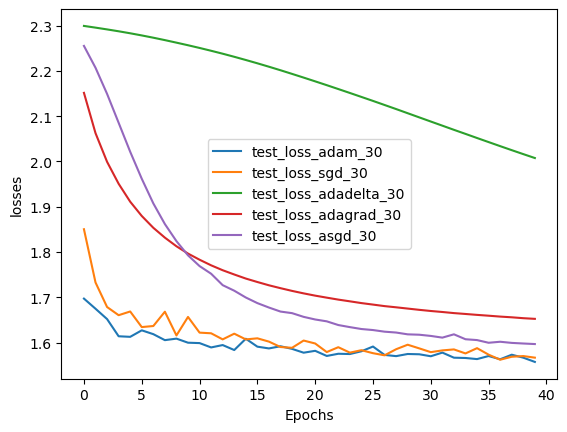

In [25]:
# Построение графика потерь
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.plot(test_loss_adam_30, label='test_loss_adam_30')
plt.plot(test_loss_sgd_30, label='test_loss_sgd_30')
plt.plot(test_loss_adadelta_30, label='test_loss_adadelta_30')
plt.plot(test_loss_adagrad_30, label='test_loss_adagrad_30')
plt.plot(test_loss_asgd_30, label='test_loss_asgd_30')
plt.legend()
plt.show()

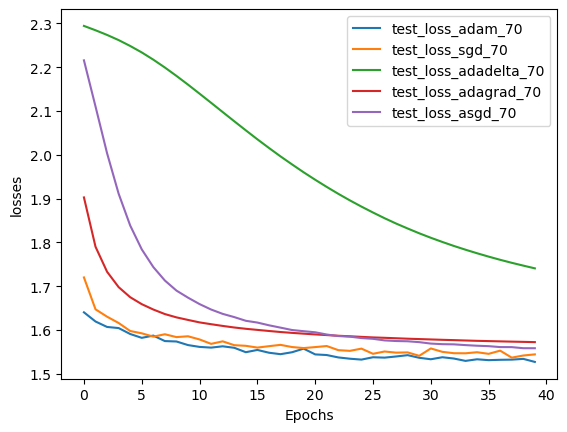

In [26]:
# Построение графика потерь
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.plot(test_loss_adam_70, label='test_loss_adam_70')
plt.plot(test_loss_sgd_70, label='test_loss_sgd_70')
plt.plot(test_loss_adadelta_70, label='test_loss_adadelta_70')
plt.plot(test_loss_adagrad_70, label='test_loss_adagrad_70')
plt.plot(test_loss_asgd_70, label='test_loss_asgd_70')
plt.legend()
plt.show()